# HHL Algorithm

> **The HHL algorithm** [\[1\]](#HHL), named after Harrow, Hassidim and Lloyd, is a fundamental quantum algorithm designed to solve a set of linear equations:
$$
A\vec{x} = \vec{b},
$$
where $A$ is an $N\times N$ matrix, and $\vec{x}$ and $\vec{b}$ are vectors of size $N = 2^n$.
    The algorithm prepares a quantum state $|x\rangle$ that encodes the solution vector proportional to $A^{-1}\vec{b}$, starting from the input state $\vec{b}$. It achieves this by applying Quantum Phase Estimation (QPE) to extract the eigenvalues of $A$, then performing a controlled rotation that effectively inverts these eigenvalues. The resulting amplitudes represent the solution state, which can be used to estimate properties of $\vec{x}$ efficiently for certain classes of matrices.
>
> The algorithm treats the problem in the following way:
>
> - **Input:** A Hermitian matrix $A$ of size $2^n\times 2^n$, normalized vector $\vec{b}$, $|\vec{b}|=1$  and given precision $m$.
> - **Promise:** $A$ is Hermitian, sparse and well-conditioned [condition number](https://en.wikipedia.org/wiki/Condition_number). In addition, the eigenvalues of $A$ lie between $1/\kappa$ and $1$, where $\kappa$ is the condition number of $A$. The enteries of vector $\vec{b}$ can be loaded efficiently to a quantum state $|b\rangle$.
> - **Output:** Solution vector encoded in the state $|x\rangle = |A^{-1}b\rangle = \sum^{2^n-1}_{j=0} \frac{\beta_j}{\tilde{\lambda}_j} |u_j\rangle_{\text{mem}}$, where: $\lambda_j$ are eigenphases of a unitary $U = e^{2\pi i A}$, estimated up to $m$ binary digits and $\beta_j$ are coefficients in expansion of initial state $|b\rangle$ into linear combination of eigenvectors of $A$, such that $|b\rangle = \sum^{2^n-1}_{j=0}\beta_j|u_j\rangle_{\text{mem}}$. The solution vector allows one to efficiently estimate $\vec{x}^T M \vec{x}$ for a Hermitian matrix $M$.
>
> **Complexity:** HHL can find a quantum representation of the solution in polylogarithmic time, with a runtime of roughly $$O(\log N \kappa^2/\epsilon)~~,$$ where $N=2^n$, and $\epsilon$ is the desired precision. In comparison, the best classical method requires polynomial time $O(\kappa N)$ (or $O(\sqrt{\kappa} N)$ for positive definite matrices). Therefore, the quantum algorithm apparently represents an exponential speedup in problem size; however, this speedup depends on strong assumptions: $A$ must be sparse, well-conditioned, and efficiently simulatable. Specifically, $\kappa$ and $1/\epsilon$ should be $O(\text{poly} \log(N))$ (i.e., upper bounded by a polynomial expression with argument $\log(N)$). Moreover, $|b\rangle$ should be loaded efficiently, and our goal is either to only estimate observables like quantities of the form $\vec{x}^T M \vec{x}$, only sample $\vec{x}$ or utilize $\vec{x}$ for further matrix computations [<a href="#supervised-learning-book">6</a>].
>
> ---
>
> **Keywords:**  Fundamental quantum algorithm, Exponential speedup, Linear equation solver

Solving linear equations appears in many research, engineering, and design fields. For example, many physical and financial models, from fluid dynamics to portfolio optimization, are described by partial differential equations, which are typically treated by numerical schemes, most of which are eventually transformed to a set of linear equations.

For simplicity, the demo below treats a use case where the matrix $A$ has eigenvalues in the interval $(0,1)$ and $|\vec{b}|=1$. Generalizations to other use cases, including the case where $|\vec{b}|\neq 1$ and $A$ is not a Hermitian matrix or not of size $2^n \times 2^n$, are discussed at the end of this notebook. 


The discussion begins with a concise overview of the algorithm, followed by its definition and implementation using Classiq’s built-in functions. We conclude by comparing the exact implementation of the algorithm with an approximate method, which is often more practical for real-world systems requiring extensive computational resources.

## Algorithm Steps

The algorithm is composed of five main steps:
1. Three registers, coined here a "memory", "estimator" and indicator are initialized with $n$, $m$, and $1$ qubits respectively and the vector $\vec{b}$ is encoded into the memory register:
  $$|0\rangle_{\text{mem}} |0\rangle_{\text{est}}|0\rangle_{\text{ind}} \xrightarrow[]{{\rm SP}} |b\rangle_{\text{mem}} |0\rangle_{\text{est}}|0\rangle_{\text{ind}}=\sum_{j=0}^{2^n-1}\beta_j| u_j \rangle_{\text{mem}}|0\rangle_{\text{est}}|0\rangle_{\text{ind}}~~,$$
where $\beta_j$ are the coefficients of $\vec{b}$ in the eigenbasis of $A$, and $|u_j\rangle$ eigenstates of $U=\exp(i 2\pi A)$.

2. Quantum Phase Estimation is applied to the initial state,
  
  $$\xrightarrow[]{{\rm QPE}} \sum^{2^n-1}_{j=0}\beta_j |u_j\rangle_{\text{mem}}|\tilde{\lambda}_j\rangle_{\text{est}}  |0\rangle_{\text{ind}}~~,$$
  where $\tilde{\lambda}_j$ are the $n$ bit approximations of the associated phases. This step can be achieved with roughly $O(\kappa^2 s/\epsilon)$ queries to $A$. 

3. Controlled rotations are applied to indicator bit $|0\rangle_{\text{ind}}$ with normalized constant $C = \frac{1}{2^n}$,

  $$\xrightarrow[]{{\rm \lambda^{-1}}} \sum^{2^n-1}_{j=0}{\beta_j |u_j\rangle_{\text{mem}}|\tilde{\lambda}_j\rangle_{\text{est}} \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_{\text{ind}} + \frac{C}{\tilde{\lambda}_j}|1\rangle_{\text{ind}} \right)}$$.

4. Eigenvalues $|\tilde{\lambda}_j\rangle_{\text{est}}$ are uncomputed with QPE$^\dagger$,

  $$\xrightarrow[]{{\rm QPE^\dagger}} \sum^{2^n-1}_{j=0}{\beta_j |u_j\rangle_{\text{mem}}|0\rangle_{\text{est}} \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_{\text{ind}} + \frac{C}{\tilde{\lambda}_j}|1\rangle_{\text{ind}} \right)}$$ $$=|\text{garbage}\rangle|0 \rangle_{\text{ind}} + \sum^{2^n-1}_{j=0}\frac{C}{\tilde{\lambda}_j}|b\rangle_{\text{mem}} |0\rangle_{\text{est}}|1\rangle_{\text{ind}}   $$.

5. Auxiliary bit value is measured: if $|1\rangle_{\text{ind}}$ is observed we obtain $$CA^{-1}|b\rangle_{\text{mem}}\propto |x\rangle ~~,$$ or otherwise repeat the algorithm.

## Preliminaries

### Defining Matrix of a Specific Problem

In [1]:
import numpy as np

# Define matrix A
A = np.array(
    [
        [0.28, -0.01, 0.02, -0.1],
        [-0.01, 0.5, -0.22, -0.07],
        [0.02, -0.22, 0.43, -0.05],
        [-0.1, -0.07, -0.05, 0.42],
    ]
)

# Define RHS vector b
b = np.array([1, 2, 4, 3])

# Normalize vector b
b = b / np.linalg.norm(b)

print("A =", A, "\n")
print("b =", b)

# Verify if the matrix is symmetric and has eigenvalues in (0,1)
if not np.allclose(A, A.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")
w, v = np.linalg.eig(A)
for lam in w:
    if lam < 0 or lam > 1:
        raise Exception("Eigenvalues are not in (0,1)")

# Binary representation of eigenvalues (classically calculated)
m = 32  # Precision of a binary representation, e.g. 32 binary digits
sign = lambda num: "-" if num < 0 else ""  # Calculate sign of a number
binary = lambda fraction: str(
    np.binary_repr(int(np.abs(fraction) * 2 ** (m))).zfill(m)
).rstrip(
    "0"
)  # Binary representation of a fraction

print()
print("Eigenvalues:")
for eig in sorted(w):
    print(f"{sign(eig)}0.{binary(eig.real)} =~ {eig.real}")

A = [[ 0.28 -0.01  0.02 -0.1 ]
 [-0.01  0.5  -0.22 -0.07]
 [ 0.02 -0.22  0.43 -0.05]
 [-0.1  -0.07 -0.05  0.42]] 

b = [0.18257419 0.36514837 0.73029674 0.54772256]

Eigenvalues:
0.00110001001110101110101000011 =~ 0.19230521285666338
0.01000000011111000101001111001011 =~ 0.2518970844513992
0.01111110111101001101011001011011 =~ 0.4959234212146716
0.10110000100110111001100111010101 =~ 0.6898742814772653


### Define Hamiltonian

We next represent the Hamiltonian into the Pauli operators. This will allow evaluating $U=e^{i 2 \pi A}$, which is utilized in the  Quantum Phase Estimation (QPE) stage and consequently, in the associated classiq function code block. Having the matrix or the Hamiltonian defined, the unitary operator can be created with the [`qpe_flexible`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb) function by passing in the `unitary_with_power` argument a callable function that applies a unitary operation raised to a given power.


The built-in function `matrix_to_pauli_operator` encodes the matrix $A$ into a sum of Pauli strings, which then allows to encode the unitary matrix $U$ with a product formula (Suzuki-Trotter). This is a classical pre-processing that can be achieved by various decomposition methods, for example, you can compare with method described in [[2](#PauliDecomposition)]. The number of qubits is stored in the variable `n`.

In [2]:
from classiq import *

hamiltonian = matrix_to_pauli_operator(A)
n = hamiltonian.num_qubits
print(f"Hamiltonian: {hamiltonian}")

print("\nNumber of qubits for matrix representation =", n)

Hamiltonian: 0.4075*Pauli.I(0)*Pauli.I(1) + -0.05249999999999999*Pauli.Z(0)*Pauli.I(1) + -0.017499999999999988*Pauli.I(0)*Pauli.Z(1) + -0.057499999999999996*Pauli.Z(0)*Pauli.Z(1) + -0.030000000000000002*Pauli.X(0)*Pauli.I(1) + 0.02*Pauli.X(0)*Pauli.Z(1) + -0.025*Pauli.I(0)*Pauli.X(1) + 0.045000000000000005*Pauli.Z(0)*Pauli.X(1) + -0.16*Pauli.X(0)*Pauli.X(1) + -0.06*Pauli.Y(0)*Pauli.Y(1)

Number of qubits for matrix representation = 2


## How to Build the Algorithm with Classiq

### The Quantum Part

#### Prepare Initial State for the Vector $\vec{b}$

The first step of the HHL algorithm involves loading the elements of the normalized RHS vector $\vec{b}$, into a quantum register:
$$
|0\rangle_{\text{mem}} \xrightarrow[{\rm SP}]{} \sum^{2^n-1}_{i=0}b_i|i\rangle_{\text{mem}}~~,
$$
where $|i\rangle$ are the states in the computational basis.

Below, we define the quantum function `load_b` using the built-in function [`prepare_amplitudes`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/qmod_core_library/prepare_state_and_amplitudes/prepare_state_and_amplitudes.ipynb). This function loads the $2^n$ elements of `amplitudes`, which correspond to the entries of the vector $\vec{b}$, into the amplitudes of the state in the output register `state`.

In [3]:
@qfunc
def load_b(amplitudes: CArray[CReal], state: Output[QArray]) -> None:
    prepare_amplitudes(amplitudes, 0.0, state)

#### Define HHL Quantum Function

The `hhl` function performs steps 2-4 of the algorithm, returning a normalized solution. Steps 2 and 4 of the algorithm are achieved by applying the  [`within_apply`](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/within-apply/) construct, where the `within` part corresponds to a flexible quantum phase estimation [`qpe_flexible`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb). The `apply` involves the controlled rotations of step 3, which are performed with `assign_amplitude_table` function. The built in function `qpe_flexible` is given a function `unitary_with_power` which indicates the powers $U^{2^k}$ are performed within the phase estimation procedure. In the following implementation, the powers are performed by Hamiltonian evolution, utilizing the `hamiltonian_evolution_with_power` function.     

The normalization coefficient $C$ ensures the amplitudes are normalized.
Since eigenvalues of $A$ are normalized to be between $1/\kappa$ and $1$, the eigenvalues of the inverse matrix are between $\kappa =1/\lambda_\text{min}$ and $1$. However, the amplitudes cannot surpass unity; we therefore choose $C$ as a lower bound of the minimum eigenvalue $C = 1/2^{n}$. 

**Arguments:**
- `unitary_with_power`: A callable function that applies a unitary operation raised to a power `k`.
- `precision`: An integer representing the precision of the phase estimation process, (number of `phase` qubits  $=n$).
- `state`: An array representing the initial quantum state $|b\rangle$ on which the matrix inversion is to be performed.
- `indicator`: An auxiliary qubit that stores the result of the inversion and indicates if the phase qubits return a normalized solution.

In [4]:
from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
precision = 4


@qfunc
def hhl(
    rhs_vector: CArray[CReal],
    precision: int,
    hamiltonian_evolution_with_power: QCallable[CInt, QArray],
    state: Output[QArray],
    phase: Output[QNum],
    indicator: Output[QBit],
):
    # Allocate a quantum number for the phase with given precision
    allocate(precision, UNSIGNED, precision, phase)

    # Prepare initial state
    load_b(amplitudes=amplitudes, state=state)

    # Allocate indicator
    allocate(indicator)
    # Perform quantum phase estimation and eigenvalue inversion within a quantum operation
    within_apply(
        lambda: qpe_flexible(
            unitary_with_power=lambda k: hamiltonian_evolution_with_power(k, state),
            phase=phase,
        ),
        lambda: assign_amplitude_table(
            lookup_table(lambda p: 0 if p == 0 else (1 / 2**phase.size) / p, phase),
            phase,
            indicator,
        ),
    )

#### Set Execution Preferences

We prepare for the quantum program execution stage by providing execution details and constructing a representation of HHL model from a function defined in Quantum Modelling Language [Qmod](https://docs.classiq.io/latest/qmod-reference/). The resulting circuit is executed on a statevector simulator. For other available Classiq simulated backends see [Execution on Classiq simulators](https://docs.classiq.io/latest/user-guide/execution/cloud-providers/classiq-backends/).

To define this part of the model, we set the backend preferences by placing `ClassiqBackendPreferences` with the backend name `SIMULATOR_STATEVECTOR` into the `ExecutionPreferences`.

In [5]:
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)


# Construct a representation of HHL model
def hhl_model(main, backend_preferences):
    qmod_hhl = create_model(
        main,
        execution_preferences=ExecutionPreferences(
            num_shots=1, backend_preferences=backend_preferences
        ),
    )
    return qmod_hhl

### The Classical Postprocess

After running the circuit a given number of times and collecting measurement results from the indicator and phase qubits we need to postprocess the data in order to find solution. Measurement values from circuit execution are denoted here by `res_hhl`.

#### Postselect Results

If all eigenvalues are $m$-estimated (are represented by $m$ binary digits), then eigenvalues uncomputation by inverse-QPE create the state:

$$
\sum^{2^m-1}_{j=0}{\beta_j |u_j\rangle_{\text{mem}} |0\rangle_{\text{est}} \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_\text{ind} + \frac{C}{\tilde{\lambda}_j}|1\rangle_\text{ind} \right)}
$$

If there is an error in step 3 and at least one eigenvalue is not $n$-estimated, then after performing QPE$^\dagger$, the `phase` register does not reset to $|0\rangle_{\text{est}}$. This will further reduce the success probability of 

In general case, we postselect only states that return $1$ for `indicator` register. In this tutorial, we will add another postselection condition on `phase` register, to return $|0\rangle_{\text{est}}$, in order to increase accuracy of the solution result.

**Note:** Postselection can improve HHL algorithm results at the cost of more executions. In the future, when two-way quantum computing is utilized, postselection might be replaced by adjoint-state preparation, as envisioned by Jarek Duda [[4](#Duda)].

The `quantum_solution` function defines a run over all the relevant strings holding the solution. The solution vector will be inserted into the variable `qsol`, after normalizing with $C=1/2^n$. After the calculation we divide by $C$ to obtain the elements of $\vec{x}$.

In [6]:
def quantum_solution(res_hhl, size, precision):

    df = res_hhl.dataframe
    qsol = np.zeros(2**size, dtype=complex)

    # Filter only the successful states.
    filtered_st = df[
        (df.indicator == 1) & (df.phase_var == 0) & (np.abs(df.amplitude) > 1e-12)
    ]

    # Allocate values
    qsol[filtered_st.res] = filtered_st.amplitude / (1 / 2**precision)

    return np.round(qsol, 5)

#### Compare Classical and Quantum Solutions
The ambiguity is resolved by isolating the global phase. Let the outcome state be $e^{i \theta}| x \rangle$, satisfying $A (e^{i \theta} | x \rangle) = e^{i\theta} |b \rangle$. We can isolate the phase by taking the scalar product of $|A e^{i \theta} | x \rangle$ with $| b \rangle $, i.e., $\langle b| A e^{i\theta}x\rangle = e^{i\theta}$. To compare between the classical and quantum solutions, we evaluate $\theta$, rotate by the appropriate angle, and take the real part.

Note that only observables of the form $\langle x| M | x\rangle$ (which are independent of the global phase) are accessible by a quantum experiment. The global phase is purely a numerical inconvenience which arises in the comparison the enteries classical solution with the quantum amplitudes and has no physical meaning in the implementation of the algorithm on actual hardware.

In [7]:
import matplotlib.pyplot as plt


def quantum_solution_preprocessed(A, b, res_hhl, precision, disp=True):
    # Classical solution
    sol_classical = np.linalg.solve(A, b)
    if disp:
        print("Classical Solution:         ", sol_classical)

    # Quantum solution with postselection
    size = len(b).bit_length() - 1
    qsol = quantum_solution(res_hhl, size, precision)
    if disp:
        print("Quantum Solution:           ", np.abs(qsol) / np.linalg.norm(qsol))

    # Global phase from one element, e.g. qsol[0]
    global_phase = np.angle(qsol[0])

    # Preprocessed quantum solution
    qsol_corrected = np.real(qsol / np.exp(1j * global_phase))

    # Correct ambiguity in the sign
    qsol_corrected = (
        np.sign(qsol_corrected[0]) * np.sign(sol_classical[0]) * qsol_corrected
    )

    return sol_classical, qsol_corrected


def show_solutions(A, b, res_hhl, precision, check=True, disp=True):
    # Classical solution and preprocessed quantum solution
    sol_classical, qsol_corrected = quantum_solution_preprocessed(
        A, b, res_hhl, QPE_SIZE, disp=disp
    )

    # Verify is there is no functional error, which might come from changing endianness in Model or Execution
    if (
        np.linalg.norm(sol_classical - qsol_corrected) / np.linalg.norm(sol_classical)
        > 0.1
        and check
    ):
        raise Exception(
            "The HHL solution is too far from the classical one, please verify your algorithm"
        )

    if disp:
        print("Corrected Quantum Solution: ", qsol_corrected)

    # Fidelity
    state_classical = sol_classical / np.linalg.norm(sol_classical)
    state_corrected = qsol_corrected / np.linalg.norm(qsol_corrected)
    fidelity = np.abs(np.dot(state_classical, state_corrected)) ** 2
    print()
    print("Fidelity:                   ", f"{np.round(fidelity * 100,2)} %")

    if disp:
        plt.plot(sol_classical, "bo", label="Classical")
        plt.plot(qsol_corrected, "ro", label="HHL")
        plt.legend()
        plt.xlabel("$i$")
        plt.ylabel("$x_i$")
        plt.show()

In the upcoming sections, we will present two different examples of implementing Hamiltonian dynamics by defining the unitary operator using two methods: exact and approximated.

### Example: Implementation of $U$ with exact Hamiltonian Simulation

The phase estimation subroutine in the HHL algorithm involves a consecutive application of controlled powers of $U$ gates, i.e, conditional $C-U^{2^0}, C-U^{2^1},\dots, C-U^{2^{m-1}}$. In the present section, we implement these gates exactly and later compare the results to an approximate evaluation of these gates.
While the implementation of exact Hamiltonian simulation provided here is not scalable for large systems due to the exponential growth in computational resources required, it serves as a valuable tool for debugging and studying small quantum systems. For sparse matrices, there is an efficient quantum algorithm for Hamiltonian simulation, see Ref. [<a href="#hamil-simul">7</a>] and the technical notes section below.

In [8]:
from typing import List

import scipy

from classiq import Output, create_model, power, prepare_amplitudes, synthesize, unitary
from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
QPE_SIZE = 4


@qfunc
def main(
    res: Output[QNum],
    phase_var: Output[QNum],
    indicator: Output[QBit],
) -> None:
    hhl(
        rhs_vector=amplitudes,
        precision=QPE_SIZE,
        hamiltonian_evolution_with_power=lambda pw, target: power(
            pw,
            lambda: unitary(
                elements=scipy.linalg.expm(2 * np.pi * 1j * A).tolist(), target=target
            ),
        ),
        state=res,
        phase=phase_var,
        indicator=indicator,
    )

In [9]:
# Construct HHL model
qmod_hhl_exact = hhl_model(main, backend_preferences)

In [10]:
from classiq import write_qmod

# Save qmod file
write_qmod(qmod_hhl_exact, "hhl_exact", decimal_precision=20, symbolic_only=False)

#### Synthesizing the Model (exact)

In [11]:
qprog_hhl_exact = synthesize(qmod_hhl_exact)
show(qprog_hhl_exact)

print("Circuit depth = ", qprog_hhl_exact.transpiled_circuit.depth)
print("Circuit CX count = ", qprog_hhl_exact.transpiled_circuit.count_ops["cx"])

Quantum program link: https://platform.classiq.io/circuit/35kD2dycimVyzeIxQfX9i1oJrGD
Circuit depth =  457
Circuit CX count =  286


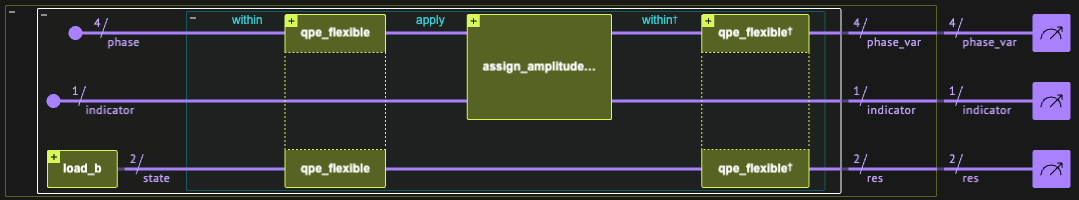
<center>
<figcaption align = "middle">Synthesized HHL circuit</figcaption>
</center>

#### Statevector Simulation (exact)

Execute the quantum program. Recall that you chose a statevector simulator because you want the exact solution.

In [12]:
from classiq.execution import ExecutionDetails

res_hhl_exact = execute(qprog_hhl_exact).result_value()

#### Results (exact)

Classical Solution:          [1.3814374  2.50585064 3.19890483 2.43147877]
Quantum Solution:            [0.2840631  0.50843613 0.64683772 0.4923432 ]
Corrected Quantum Solution:  [1.43559 2.56952 3.26897 2.48819]

Fidelity:                    100.0 %


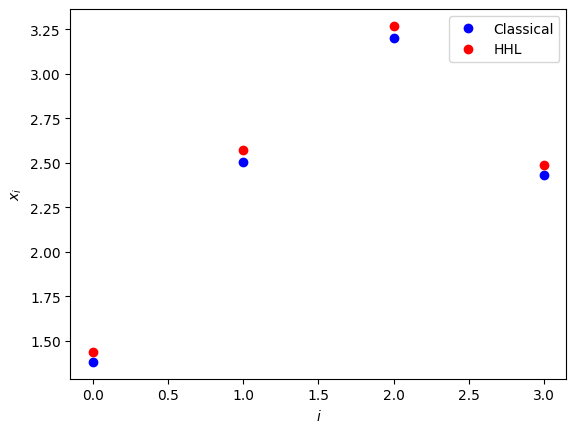

In [13]:
precision = QPE_SIZE
show_solutions(A, b, res_hhl_exact, precision, check=False)

### Example: Approximated Hamiltonian Evolution (Suzuki-Trotter)

The approximated Hamiltonian simulation is capable of handling larger and more complex systems, making it more suitable for real-world applications where exact solutions are computationally prohibitive.

We will define the inner quantum call to be used within the flexible QPE: a Suzuki Trotter of order one [[3](#Trotter)], whose repetitions parameter grows by some constant factor proportional to the evolution coefficient.

For the QPE we are going to use Classiq's `suzuki-trotter` function of order one for Hamiltonian evolution $e^{-i H t}$. This function is an approximated one, where its `repetitions` parameter controls its error. For a QPE algorithm with estimator size $n$ a series of controlled-unitaries $U^{2^s}$ with $0 \leq s \leq n-1$ are applied, for each of which we would like to pass a different `repetitions` parameter depth (to keep a roughly same error, the repetitions for approximating $U=e^{2\pi i 2^s A }$ is expected to be $\sim 2^s$ times the repetitions of $U=e^{2\pi i A }$). In Classiq this can be done by working with a [`qpe_flexible`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb), and passing a "rule" for how to exponentiate each step within the QPE in `repetitions` parameter.

In [14]:
from classiq.qmod.symbolic import ceiling, log


def suzuki_trotter1_with_power_logic(
    hamiltonian: SparsePauliOp,
    pw: CInt,
    r0: CInt,
    reps_scaling_factor: CReal,
    evolution_coefficient: CReal,
    target: QArray,
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=1,
        repetitions=r0 * ceiling(reps_scaling_factor ** (log(pw, 2))),
        qbv=target,
    )

The parameters `R0` and `REPS_SCALING_FACTOR` dictate the number of repititions in the Suzuki-Trotter approximation. The specific number of repititions depend on the Hamiltonian, and therefore, were chosen by trial and error. For other examples, one would need to use different values for these parameters, please compare with specific example in [Flexible QPE tutorial](https://github.com/Classiq/classiq-library/blob/main/tutorials/advanced_tutorials/high_level_modeling_flexible_qpe/high_level_modeling_flexible_qpe.ipynb). The relevant literature that discusses the errors of product formulas is available in Ref. [[5](#trotter-error)].

In [15]:
from classiq.qmod.symbolic import floor

# parameters for the amplitude preparation
amplitudes = b.tolist()

# parameters for the QPE
QPE_SIZE = 4

R0 = 4
REPS_SCALING_FACTOR = 1.8


@qfunc
def main(
    res: Output[QNum],
    phase_var: Output[QNum],
    indicator: Output[QBit],
) -> None:
    hhl(
        rhs_vector=amplitudes,
        precision=QPE_SIZE,
        hamiltonian_evolution_with_power=lambda pw, target: suzuki_trotter1_with_power_logic(
            hamiltonian=hamiltonian,
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            r0=R0,
            reps_scaling_factor=REPS_SCALING_FACTOR,
            target=target,
        ),
        state=res,
        phase=phase_var,
        indicator=indicator,
    )


# Define model
qmod_hhl_trotter = hhl_model(main, backend_preferences)

In [16]:
# Save qmod file
write_qmod(qmod_hhl_trotter, "hhl_trotter", decimal_precision=10, symbolic_only=False)

Quantum program link: https://platform.classiq.io/circuit/35kD4k8RhJQmRlZQ43tGtjDn0mR
Circuit depth =  5069
Circuit CX count =  2966

Classical Solution:          [1.3814374  2.50585064 3.19890483 2.43147877]
Quantum Solution:            [0.28600641 0.5107414  0.64756839 0.48785114]
Corrected Quantum Solution:  [1.4399586  2.54984965 3.2534983  2.43124679]

Fidelity:                    99.99 %


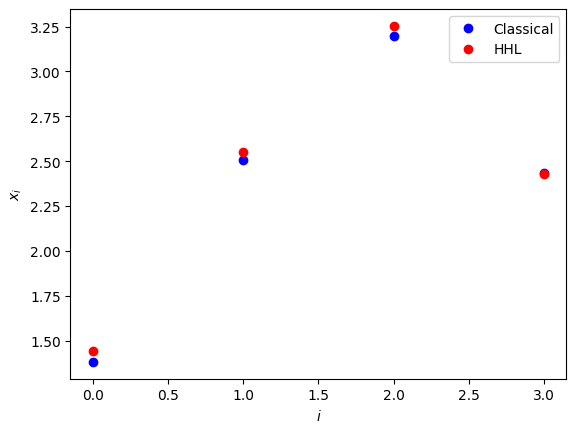

In [17]:
# Synthesize
qprog_hhl_trotter = synthesize(qmod_hhl_trotter)
show(qprog_hhl_trotter)

# Show circuit
print("Circuit depth = ", qprog_hhl_trotter.transpiled_circuit.depth)
print("Circuit CX count = ", qprog_hhl_trotter.transpiled_circuit.count_ops["cx"])
print()

# Show results
res_hhl_trotter = execute(qprog_hhl_trotter).result_value()
show_solutions(A, b, res_hhl_trotter, precision)

We explored the HHL algorithm for solving linear systems using exact and approximated Hamiltonian simulations. The exact method, with a smaller circuit depth, is computationally less intensive but lacks scalability. In contrast, the approximated method, with a greater circuit depth, offers flexibility and can handle larger, more complex systems. This trade-off underscores the importance of selecting the appropriate method based on the problem's size and complexity.

## Technical Notes

- The condition on the sparsity of $A$ arises from the following result, Ref. [<a href="#hamil-simul">7</a>]: If $A$ is a $2^n \times 2^n$ Hermitian $s$-spase matrix then one can implement an Hamiltonian simulation, $e^{-iA t}$ up to error $\epsilon$ in the spectral norm with $$O\left( st||A||_{\infty} + \frac{1/\epsilon}{\log \log (1/\epsilon)}\right) $$ queries to $A$ and a total number of gates which is larger by a factor of $n$. Here, the infinity norm corresponds to the largest entry of $A$.
- Before measurement we obtain the state $$ C|A^{-1}b\rangle_{\text{mem}} |0\rangle_{\text{est}}|1\rangle_{\text{ind}} +|\text{garbage}\rangle|0 \rangle_{\text{ind}}~~.$$ Naively, one would require of order $1/C=O(2^n)$ measurements to obtain a sample of the entries of $|x\rangle$. However, utilizing quantum amplitude amplification one can obtain a quadratic speedup, sampling the state with an order of only $O(2^{n/2})$ measurements.
- We can replace the sparsity condition on $A$ by any 
- The complexity of standard HHL algorithm is $O(\log n \kappa^2 s/\epsilon)$. The factor $1/\epsilon$ has been improved by Childs et al. in [[8](#Childs)] to $\log(\kappa/\epsilon)$, and Ambainis introduced a generalization of amplitude amplification, which allows reducing the quadratic $\kappa$ dependence to linear [[9](#Ambainis)].


### Generalizations

The use case treated above is a canonical one, assuming the following properties:
- The RHS vector $\vec{b}$ is normalized.
- The matrix $A$ is an Hermitian one.
- The matrix $A$ is of size $2^n\times 2^n $.
- The eigenvalues of $A$ are in the range $(0,1)$.

However, any general problem that does not follow these conditions can be resolved as follows:

1) Normalize $\vec{b}$ and return the normalization factor

2) Symmetrize the problem as follows:
$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{x}
\end{pmatrix}.
$$
**Note:** This requires only a single additional qubit.

3) Complete the matrix dimension to the closest $2^n$ with an identity matrix and the vector $\vec{b}$ will be completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}~~.
$$

4) If the eigenvalues of $A$ are in the range $[-w_{\min},w_{\max}]$ you can employ transformations to the exponentiated matrix that enters into the Hamiltonian simulation, and then undo them for extracting the results:
$$
\tilde{A}=\frac{A+w_{\min}I}{w_{\min}+w_{\max}}~~.
$$
The eigenvalues of this matrix lie in the interval $[0,1)$, and are related to the eigenvalues of the original matrix via
$$
\lambda = (w_{\min}+w_{\max})\tilde{\lambda}-w_{\min},
$$
with $\tilde{\lambda}$ being an eigenvalue of $\tilde{A}$ resulting from the QPE algorithm. This relation between eigenvalues is utilized in the pre and post-processing of the results or directly in the amplitude loading procedure.

## References

<a name='HHL'>[1]</a>: [Harrow, A. W., Hassidim, A., & Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Physical review letters, 103(15), 150502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502).

<a name='PauliDecomposition'>[2]</a>: [Hantzko, L., Binkowski, L., & Gupta, S. (2024). Tensorized Pauli decomposition algorithm. Physica Scripta, 99(8), 085128.](https://arxiv.org/abs/2310.13421).

<a name='Trotter'>[3]</a>: [Hatano, N., & Suzuki, M. (2005). Finding exponential product formulas of higher orders. In Quantum annealing and other optimization methods (pp. 37-68)](https://arxiv.org/abs/math-ph/0506007).

<a name='Duda'>[4]</a>: [Duda, J. (2023). Two-way quantum computers adding CPT analog of state preparation. arXiv preprint arXiv:2308.13522.](https://arxiv.org/abs/2308.13522).

<a name='trotter-error'>[5]</a>: [Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., & Zhu, S. (2021). Theory of trotter error with commutator scaling. Physical Review X, 11(1), 011020.](https://arxiv.org/abs/2308.13522).

<a name='supervised-learning-book'>[6]</a>: [Schuld, Maria, and Francesco Petruccione. (2018). Supervised learning with quantum computers. Quantum science and technology 17](supervised-learning-book)

<a name='hamil-simul'>[7]</a>: [Low, Guang Hao, and Isaac L. Chuang. (2017). Optimal Hamiltonian simulation by quantum signal processing. Physical review letters 118.1 010501.](https://arxiv.org/abs/1606.02685)

<a name='Childs'>[8]</a>: [Childs, A. M., Kothari, R., & Somma, R. D. (2017). Quantum algorithm for systems of linear equations with exponentially improved dependence on precision. SIAM Journal on Computing, 46(6), 1920-1950.](https://arxiv.org/abs/1511.02306)

<a name='Ambainis'>[9]</a>: [Ambainis, A. (2010). Variable time amplitude amplification and a faster quantum algorithm for solving systems of linear equations.](https://arxiv.org/abs/1010.4458)